## Preprocessing of imaging data: Volume vs. projection to single plane

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
from os.path import sep, exists
from os import mkdir, makedirs, getcwd
import napari

In [18]:
from fly2p.viz.viz import myAxisTheme
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
import fly2p.preproc.imgPreproc as imp

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### (1) Load, parse metadata and generate data object
#### Set paths to data files and plot directory

In [3]:
rootDir = '../../../../data_unityvr'
dataDir = sep.join([rootDir, 'raw','dFB','84C10_x_6fdouble','FB','deprived','f01'])
rawTiff = '84C10_x_6fdouble_f01_FB_depr_00001.tif'
plotDir = sep.join([rootDir, 'plot', sep.join(dataDir.split(sep)[-4:])])
preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-4:])])
print(plotDir)

../../../../data_unityvr/raw/dFB/84C10_x_6fdouble/FB/deprived/f01
../../../../data_unityvr/plot/84C10_x_6fdouble/FB/deprived/f01


In [15]:
genotype = '-'.join(rawTiff.split('_')[0:3])
[flyID, region] = rawTiff.split('_')[3:5]
condition = rawTiff.split('_')[-2]
trial = rawTiff.split('_')[-1][:-4]
print('Genotype: {}, Imaging region: {}, Fly id: {}\nCondition: {}, Trial: {}'.format(
    genotype, region, flyID, condition, trial))

# Generate directory where to save plots
saveDir = sep.join([plotDir, condition])
if not exists(saveDir):
    makedirs(saveDir)

Genotype: 84C10-x-6fdouble, Imaging region: FB, Fly id: f01
Condition: depr, Trial: 00001


#### Load imaging data and extract metadata
Extract relevant information from header

In [13]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
metadat = mytiffreader.metadata()
basicMetadat = getSIbasicMetadata(metadat)
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(metadat)

basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


{'nCh': 1,
 'fpsscan': 73.3861,
 'discardFBFrames': 'true',
 'nDiscardFBFrames': 2,
 'fpv': 10,
 'nVols': 3523,
 'stackZStepSize': 3,
 'scanVolumeRate': 7.33861,
 'fovCoords': {'p00': [-25.3125, -25.3125],
  'p10': [25.3125, 25.3125],
  'p01': [25.3125, -25.3125],
  'p11': [-25.3125, 25.3125]},
 'xrange_um': 50.625,
 'yrange_um': 50.625,
 'CaCh': 0}

Read and reshape image tiff stack

In [19]:
stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

### Motion correction
#### Correct translation in x/y using phase correlation

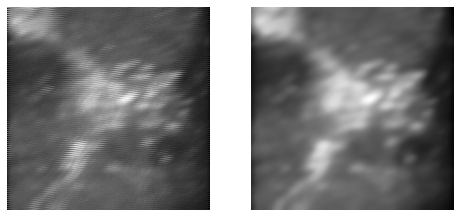

In [11]:
# Settings
## reference image
numRefImg = 600
locRefImg = round(np.max(imgStack, axis=1)['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(np.max(imgStack, axis=1)[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower')
axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower')
axs[1].axis('off');

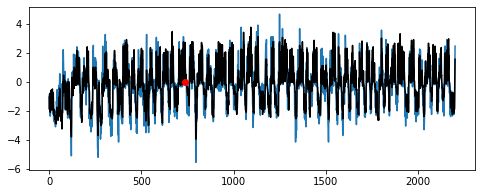

In [12]:
stackMPMC, shift = imp.motionCorrection(np.max(imgStack, axis=1), refImg, 20, 2)

fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(shift[0,:])
ax.plot(shift[1,:],'k')
ax.plot(locRefImg,0,'ro')

In [13]:
#viewerMPMC = napari.view_image(stackMPMC)

#### Apply estimated motion to 4d stack
We assume here that all planes in a volume at a given time moved together

In [14]:
stack4dMC = imp.applyShiftTo4Dstack(imgStack, shift)

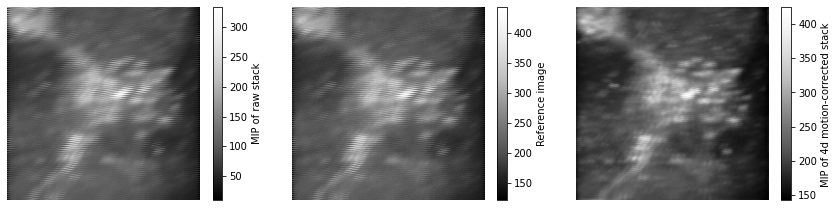

In [15]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
cb = axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

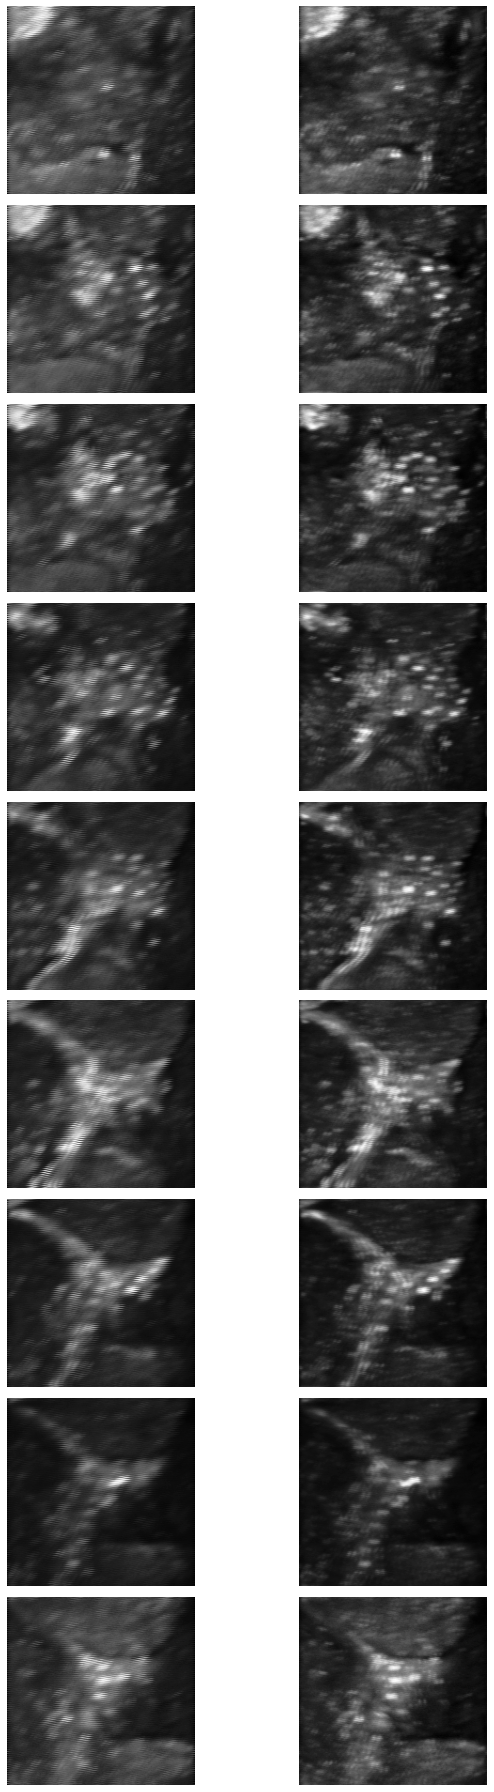

In [16]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2, figsize=(10, 25))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i,0].imshow(imgStack[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,1].imshow(stack4dMC[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,0].axis('off')
    ax[i,1].axis('off');
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['meanSignal_beforeAfterMC_',genotype, region, flyID, age, condition, trial])+'.pdf')

### Perform correlation analysis to get ROIs

#### (1) Compute DFF

In [17]:
# Settings
# filter DF/F trace with Savitzky-Golay filter
from scipy.signal import savgol_filter

# 3rd order, 7 frames
order = 3
window = 7

# Currently F_0 is estimated for the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

(a) one plane

In [18]:
dffStackMC = np.zeros((stackMPMC.shape)) 
stackF0 = np.zeros((stackMPMC["xpix [µm]"].size,stackMPMC["ypix [µm]"].size)) 

filtStack = gaussian_filter(stackMPMC, sigma=[0,2,2])

filtF = savgol_filter(filtStack.astype('float'), window, order, axis=0)

# Estimate baseline
stackF0 = np.percentile(filtF, baseLinePercent, axis=0) + offset
stackF0[np.where(stackF0 == 0)[0]] += offset

# Compute dF/F_0 = (F_raw - F_0)/F_0
dffStackMC = (filtF - stackF0) / stackF0

dffMP = np.max(dffStackMC, axis=0)

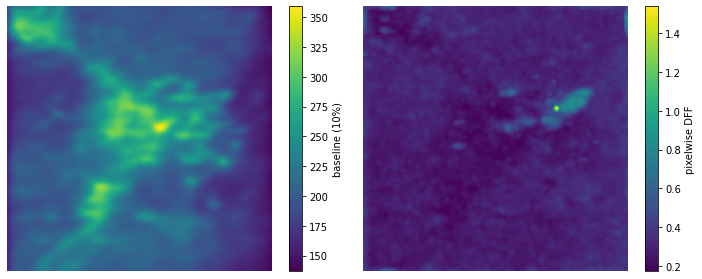

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='lower')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='lower')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)

(b) volume

In [20]:
dffStack4dMC = np.zeros((stack4dMC.shape)) 
stackF0vol = np.zeros((stack4dMC["planes [µm]"].size, stackMPMC["xpix [µm]"].size, stackMPMC["ypix [µm]"].size)) 

for p in range(stack4dMC["planes [µm]"].size):
    filtStack = gaussian_filter(stack4dMC[{'planes [µm]': p}].squeeze(), sigma=[0,2,2])

    filtF = savgol_filter(filtStack.astype('float'), window, order, axis=0)

    # Estimate baseline
    stackF0vol[p,:,:] = np.percentile(filtF, baseLinePercent, axis=0) + offset
    stackF0vol[p,np.where(stackF0vol[p,:,:] == 0)[0]] += offset

    # Compute dF/F_0 = (F_raw - F_0)/F_0
    dffStack4dMC[:,p,:,:] = (filtF - stackF0vol[p,:,:]) / stackF0vol[p,:,:]

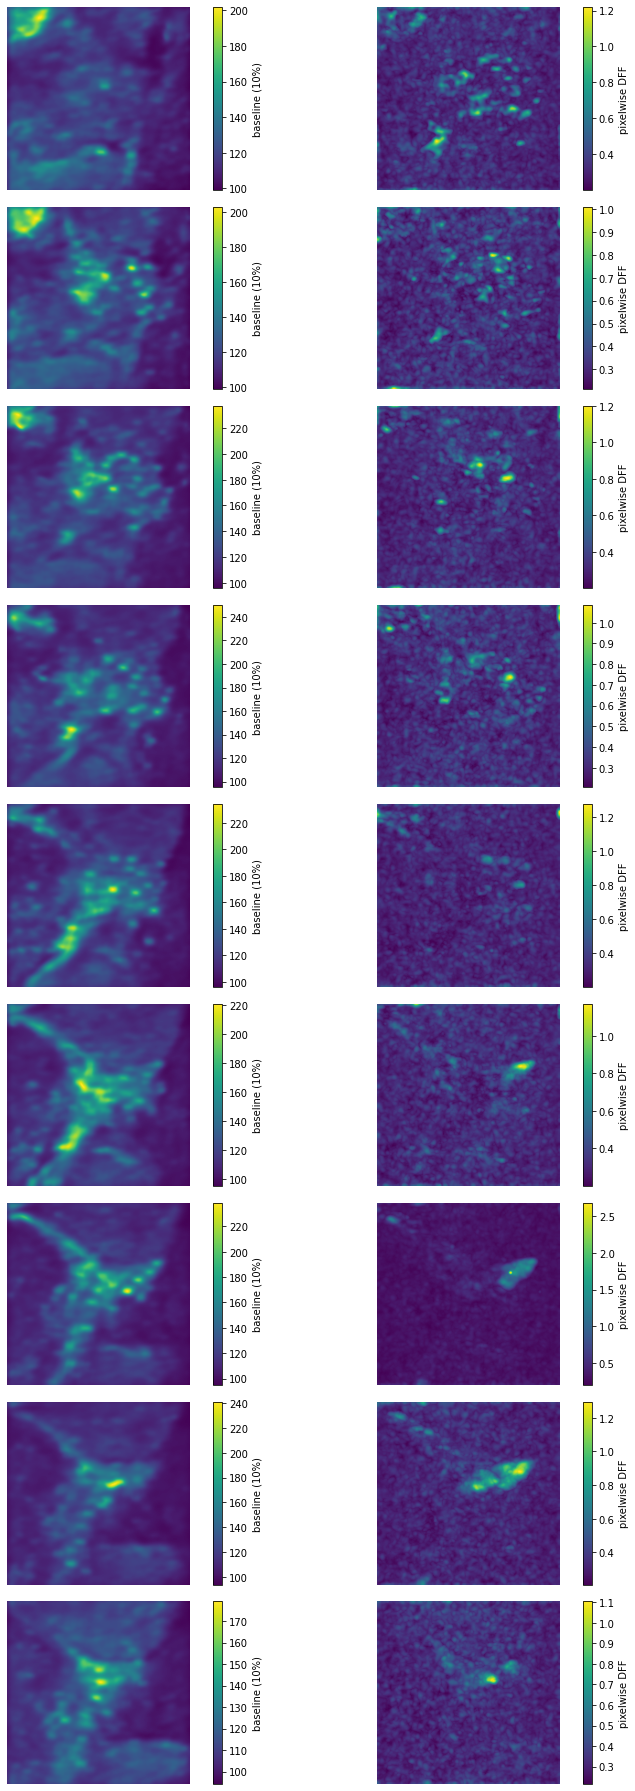

In [21]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2,figsize=(12,25))
for i in range(stack4dMC["planes [µm]"].size):
    cb = ax[i,0].imshow(stackF0vol[i,:,:],cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,0], label='baseline ({}%)'.format(baseLinePercent))
    ax[i,0].axis('off')
    
    cb = ax[i,1].imshow(np.max(dffStack4dMC[:,i,:,:],axis=0),cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,1], label='pixelwise DFF')
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFFperPlane_beforeAfterMC_',genotype, region, flyID, age, condition, trial])+'.pdf')

In [ ]:
#viewerdff1 = napari.view_image(dffStack4dMC)

#### (2) Define regions on which to perform clustering
Mark the area that should be considered with the napari labeling tool in a layer named "mask".

(a) Single plane mask for max projection

In [22]:
viewer = napari.view_image(refImgFilt)

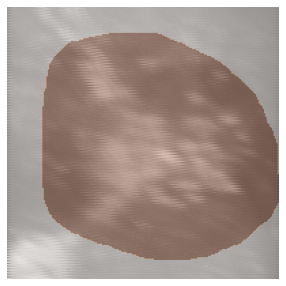

In [23]:
# you can draw a mask:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='lower')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.3)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

(b) 3D mask for volume processing

In [24]:
refStack = stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = stack4dMC[:,i,:,:].mean(axis=0)
    
viewer3D = napari.view_image(refStack)

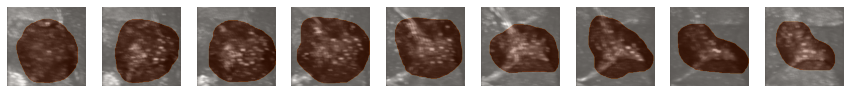

In [26]:
mask3D = viewer3D.layers["mask"]

fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(refStack[i,:,:],cmap='Greys_r',origin='lower')  
    ax[i].axis('off');
    ax[i].imshow(mask3D.data[i,:,:], cmap='Oranges', alpha=0.35)
    
fig.savefig(saveDir+sep+'_'.join(['mask3D',genotype, region, flyID, age, condition, trial])+'.pdf')

#### (3) Perform clustering on pixels in mask

TODO: Check time axis generatiton

In [41]:
# Settings
from sklearn.cluster import KMeans

nclst = 6 # 4 for FBt

One plane

In [42]:
dffMask = np.logical_and(mask.data>0, np.std(dffStackMC, axis=0) > 0.08)
toClust = dffStackMC[:,dffMask]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=6)

In [43]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [44]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

kmlabsImg = np.nan*np.ones(dffMask.shape)

kmlabsImg[dffMask] = kmlabs

ypos = np.repeat(np.arange(dffMask.shape[0]),dffMask.shape[1]).reshape(dffMask.shape)
yPosClust = np.zeros(nclst)
for i in range(nclst):
    yPosClust[i] = dffMask.shape[0]-np.median(ypos[kmlabsImg==i])
    
centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

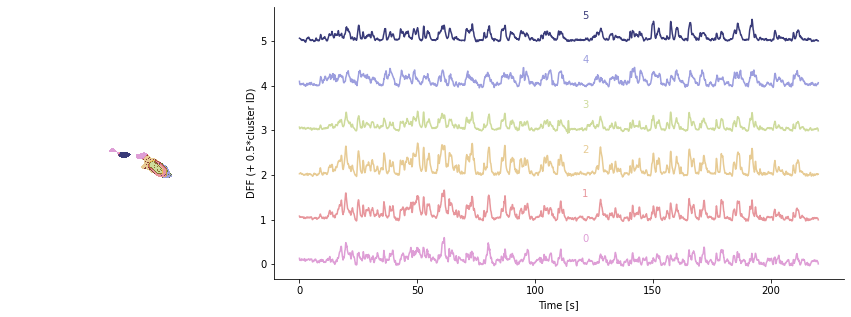

In [45]:
fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids2Plot[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

<ipython-input-46-345e5cd425fc>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


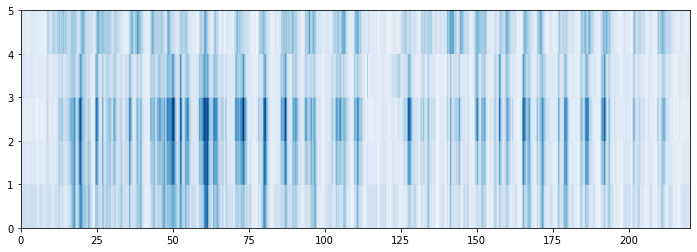

In [46]:
fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

Volume

In [47]:
nclst_4d = 10

dffMask = np.logical_and(mask3D.data>0, np.std(dffStack4dMC, axis=0) > 0.08)
toClust = dffStack4dMC[:,dffMask]

kmeans_4d = KMeans(n_clusters=nclst_4d)
kmeans_4d.fit(toClust.T)

KMeans(n_clusters=10)

In [48]:
kmlabs_4d = kmeans_4d.predict(toClust.T)
centroids_4d = kmeans_4d.cluster_centers_

In [49]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst_4d)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

#time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

<ipython-input-51-3e170c36594a>:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


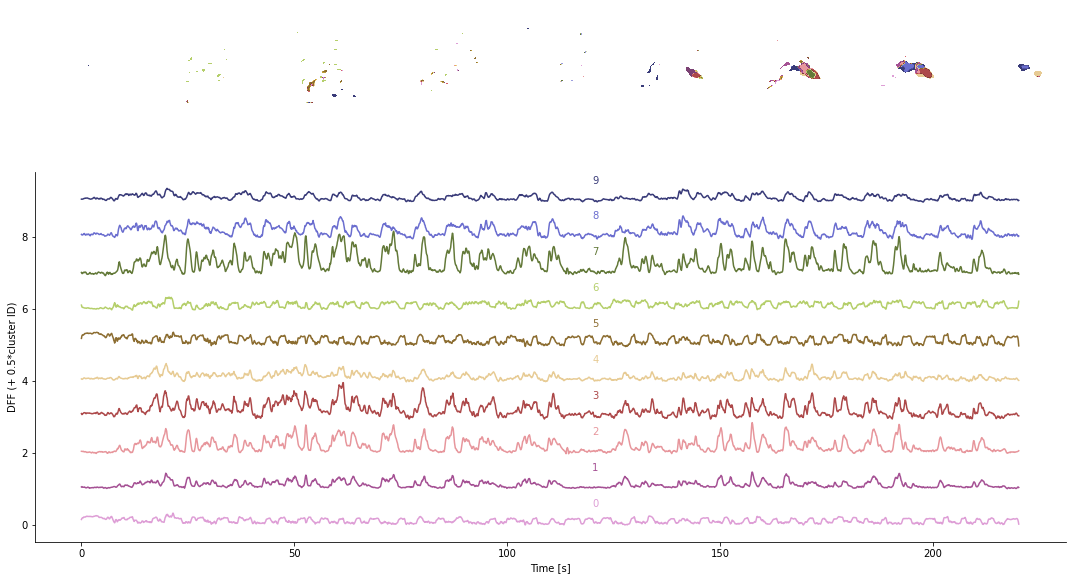

In [51]:
kmlabsImg_3d = np.nan*np.ones(mask3D.data.shape)

kmlabsImg_3d[dffMask] = kmlabs_4d

fig = plt.figure(constrained_layout=True,figsize=(15,10))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(2,stack4dMC["planes [µm]"].size)

for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[0,p])
    ax.imshow(kmlabsImg_3d[p,:,:],cmap=myClstMap,origin='upper')
    ax.axis('off')

ax = fig.add_subplot(gs[1,:])
for i in range(nclst_4d):
    ax.plot(time,centroids_4d[i]+i, color=clstCMap.to_rgba(i+1))
    ax.text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
ax.set_xlabel('Time [s]')
ax.set_ylabel('DFF (+ 0.5*cluster ID)')
#ax.set_ylim(0, 1+nclst_4d)
myAxisTheme(ax)
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

<ipython-input-51-e68076497607>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


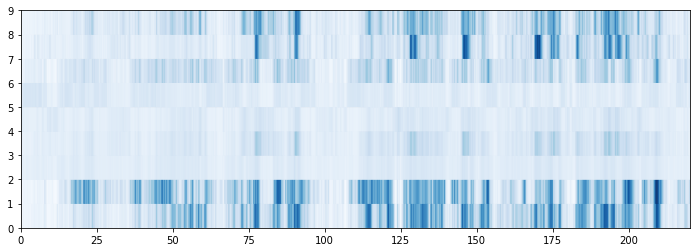

In [51]:
centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trikmlabsImg_3d')

#### Generate data object and save to disk

In [437]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

roiDf = pd.DataFrame(data = centroids2Plot.T, 
                     columns = ['background'] + ['wedge{}'.format(i+1) for i in range(8)])
roiDf['time [s]']  = time

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat, expMetadata = expMetadata,
    refImage = refImg, refStackMC = np.mean(stackMPMC,axis=0), dffStack = np.max(dffXarray,axis=0), 
    roitype = "corr",roiMask = kmlabsImg, roiDFF = roiDf
)

# Generate directory where to save plots
ppsaveDir = sep.join([preprocDir, condition])
imgTS_corrroi.saveData(ppsaveDir, trial)